In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Requirements**

In [2]:
!apt-get -y install tesseract-ocr && pip install ultralytics pytesseract opencv-python-headless pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00


# **Updated Masking logic**

In [3]:
# CELL 1
# Function: loads YOLOv8 model (pretrained) and masks Aadhaar numbers.
# Behaviors:
# - blur exactly inside detection box (no padding)
# - stronger blur (adaptive)
# - pick highest-confidence detection, OCR that region, use its last4 on all detected boxes
# - larger overlay text
from ultralytics import YOLO
import cv2
import numpy as np
import pytesseract
import re
from PIL import Image

def extract_aadhaar_from_text(text):
    if not text:
        return None
    t = text.upper()
    t = t.replace("O","0").replace("B","8").replace("S","5").replace("I","1").replace("|","1")
    t = re.sub(r'[^0-9]', '', t)  # keep only digits
    # look for 12-digit Aadhaar
    m = re.search(r'(\d{12})', t)
    if m:
        return m.group(1)
    return None

def mask_aadhaar_image_v2(image_path, model_path,
                          output_path="/content/aadhaar_masked.png",
                          conf_keep_thresh=0.05,   # keep detections from model above this before selecting
                          ocr_upsample=3,
                          max_blur_kernel=121):
    """
    Loads YOLOv8 model at model_path and masks aadhaar numbers in image_path.
    Returns masked_image (BGR numpy). Saves to output_path if provided.
    """

    # --- read image robustly ---
    try:
        img_bgr = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    except Exception:
        img = Image.open(image_path).convert("RGB")
        img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    if img_bgr is None:
        raise ValueError("Could not read image. Check path.")
    h_img, w_img = img_bgr.shape[:2]
    masked = img_bgr.copy()

    # --- load model ---
    model = YOLO(model_path)

    # --- run inference ---
    results = model.predict(source=img_bgr, imgsz=640, conf=0.01, verbose=False)
    res0 = results[0]

    # safe extract boxes & confs
    try:
        boxes = res0.boxes.xyxy.cpu().numpy().astype(int)   # (N,4)
        confs = res0.boxes.conf.cpu().numpy().astype(float)
    except Exception:
        boxes = []
        confs = []
        for b in res0.boxes:
            xy = b.xyxy[0].cpu().numpy().astype(int)
            boxes.append(xy)
            confs.append(float(b.conf))
        boxes = np.array(boxes).astype(int) if boxes else np.empty((0,4), dtype=int)
        confs = np.array(confs).astype(float) if confs else np.array([])

    if boxes.shape[0] == 0:
        # nothing detected: return original and optionally save
        if output_path:
            cv2.imwrite(output_path, masked)
        return masked

    # filter boxes with at least a minimal conf
    keep_idx = [i for i,c in enumerate(confs) if c >= conf_keep_thresh]
    if len(keep_idx) == 0:
        keep_idx = list(range(len(confs)))

    boxes = boxes[keep_idx]
    confs = confs[keep_idx]

    # --- Choose highest-confidence box to OCR first ---
    order = np.argsort(-confs)  # descending
    extracted_number = None
    extracted_idx = None

    ocr_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'

    for idx in order:
        x1,y1,x2,y2 = boxes[idx]
        # clip
        x1 = max(0, min(w_img-1, int(x1))); x2 = max(0, min(w_img-1, int(x2)))
        y1 = max(0, min(h_img-1, int(y1))); y2 = max(0, min(h_img-1, int(y2)))
        if x2 <= x1 or y2 <= y1:
            continue
        roi = img_bgr[y1:y2, x1:x2]
        if roi.size == 0:
            continue
        # OCR on upscaled grayscale
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        up = max(1, int(ocr_upsample))
        gray_up = cv2.resize(gray, None, fx=up, fy=up, interpolation=cv2.INTER_LINEAR)
        _,th = cv2.threshold(gray_up, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        t1 = pytesseract.image_to_string(th, config=ocr_config)
        t2 = pytesseract.image_to_string(gray_up, config=ocr_config)
        text = t1 if sum(c.isdigit() for c in t1) >= sum(c.isdigit() for c in t2) else t2
        num = extract_aadhaar_from_text(text)
        if num:
            extracted_number = num
            extracted_idx = idx
            break

    # if no box produced OCR result, extracted_number stays None -> fallback later
    last4 = extracted_number[-4:] if extracted_number else None

    # --- For each detected box, apply blur (within box exactly) and overlay same masked text ---
    # masked_text uses last4 if available else 'XXXX'
    overlay_last4 = last4 if last4 else "XXXX"
    masked_text_to_put = f"XXXX XXXX {overlay_last4}"

    for i in range(boxes.shape[0]):
        x1,y1,x2,y2 = boxes[i]
        x1 = max(0, min(w_img-1, int(x1))); x2 = max(0, min(w_img-1, int(x2)))
        y1 = max(0, min(h_img-1, int(y1))); y2 = max(0, min(h_img-1, int(y2)))
        if x2 <= x1 or y2 <= y1:
            continue

        # --- strong blur inside the exact detection box (no padding) ---
        roi = masked[y1:y2, x1:x2]
        bw = max(1, x2-x1); bh = max(1, y2-y1)
        # stronger kernel: proportional to smaller box dimension but larger multiplier
        k = int(min(bw, bh) * 0.6)   # higher factor for stronger blur
        if k % 2 == 0:
            k += 1
        if k < 15:
            k = 15
        if k > max_blur_kernel:
            k = max_blur_kernel if max_blur_kernel % 2 == 1 else max_blur_kernel-1
        blurred_roi = cv2.GaussianBlur(roi, (k, k), 0)
        masked[y1:y2, x1:x2] = blurred_roi

        # --- overlay larger masked text (centered inside detection box) ---
        font = cv2.FONT_HERSHEY_SIMPLEX
        # target text height ~ 25% of box height (larger than previous)
        desired_text_h = max(18, int(bh * 0.25))
        test_scale = 1.0
        (tw, th), _ = cv2.getTextSize(masked_text_to_put, font, test_scale, 2)
        font_scale = test_scale * (desired_text_h / th) if th > 0 else 1.0
        thickness = max(1, int(round(font_scale * 2.2)))

        text_size = cv2.getTextSize(masked_text_to_put, font, font_scale, thickness)[0]
        text_w, text_h = text_size

        box_cx = x1 + (bw // 2)
        box_cy = y1 + (bh // 2)
        text_x = int(box_cx - text_w / 2)
        text_y = int(box_cy + text_h // 2)

        # clamp
        text_x = max(0, min(w_img - text_w, text_x))
        text_y = max(text_h, min(h_img - 1, text_y))

        # draw filled white rectangle behind text for contrast
        pad_x = max(10, int(text_w * 0.06))
        pad_y = max(6, int(text_h * 0.25))
        rx1 = max(0, text_x - pad_x)
        ry1 = max(0, text_y - text_h - pad_y)
        rx2 = min(w_img-1, text_x + text_w + pad_x)
        ry2 = min(h_img-1, text_y + pad_y)
        cv2.rectangle(masked, (rx1, ry1), (rx2, ry2), (255,255,255), -1)
        cv2.putText(masked, masked_text_to_put, (text_x, text_y), font, font_scale, (0,0,0), thickness, cv2.LINE_AA)

    # --- Save and return ---
    if output_path:
        cv2.imwrite(output_path, masked)
    return masked

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Test code**

Original Image:


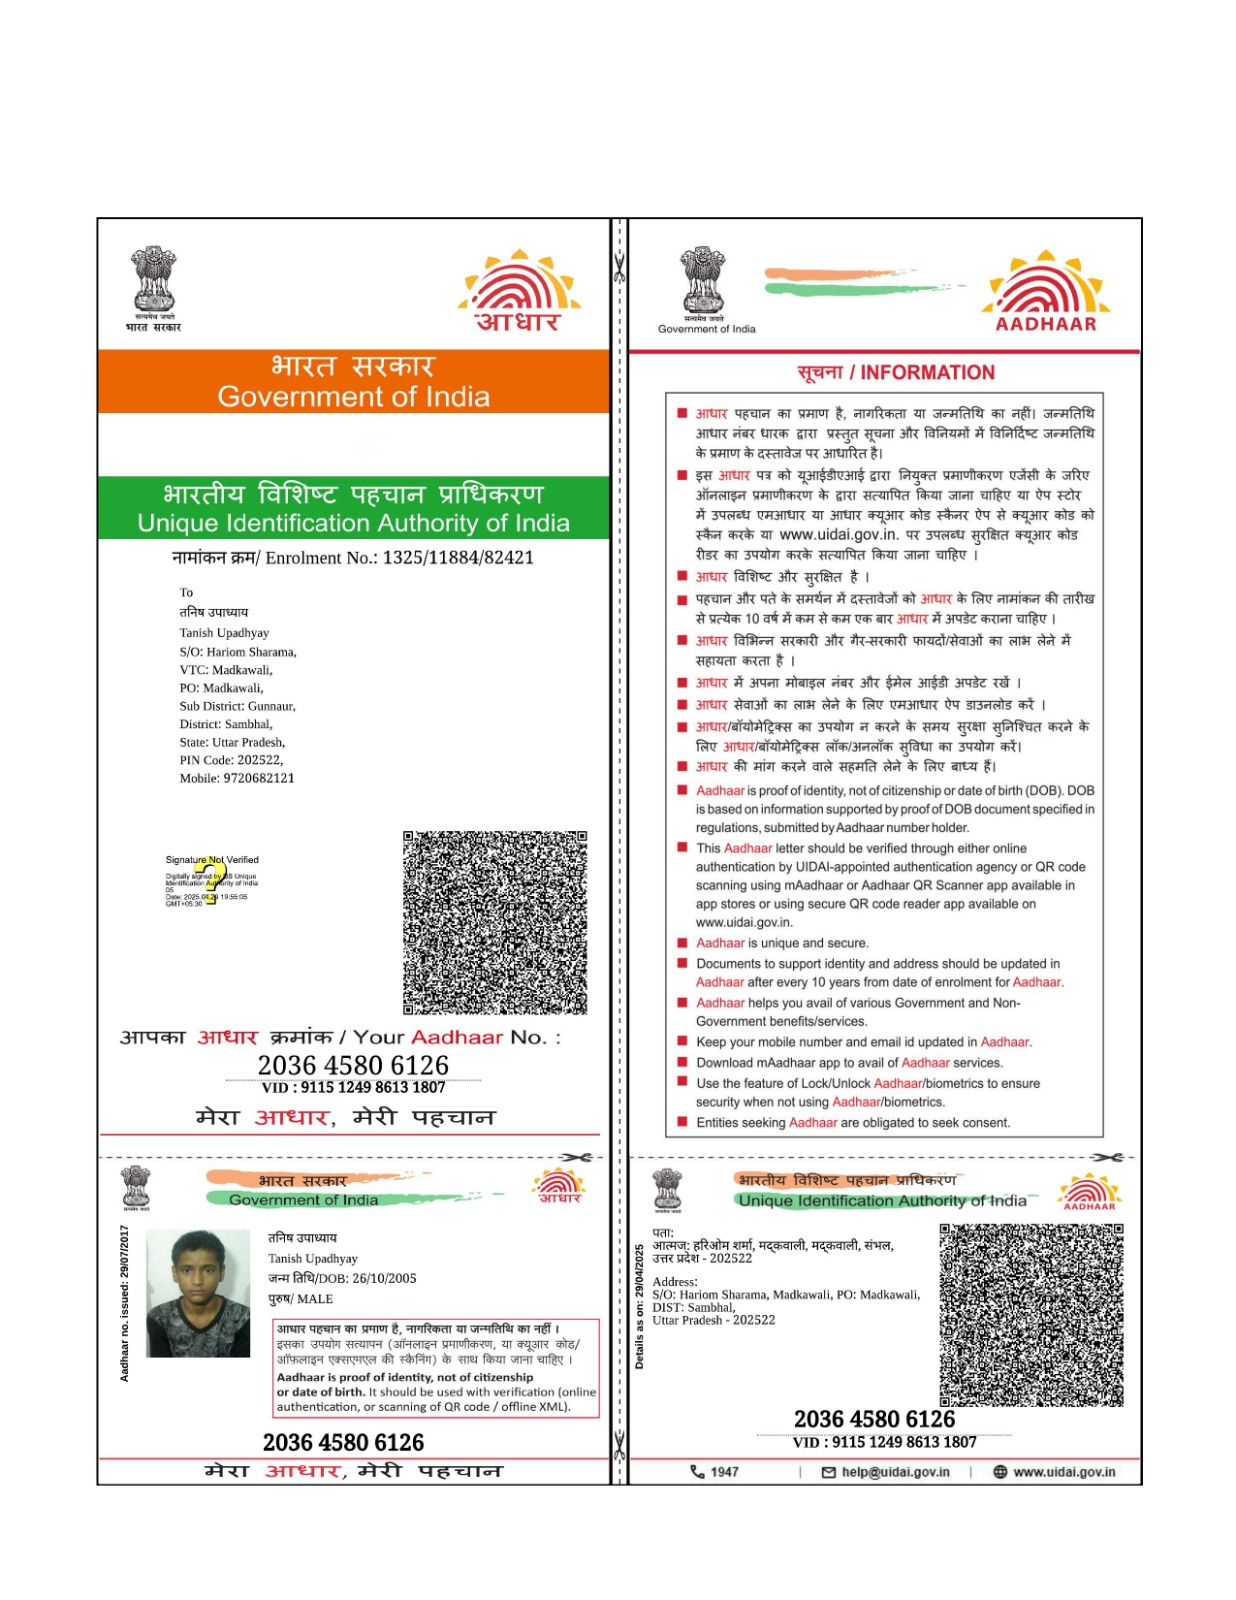

Masked Image:


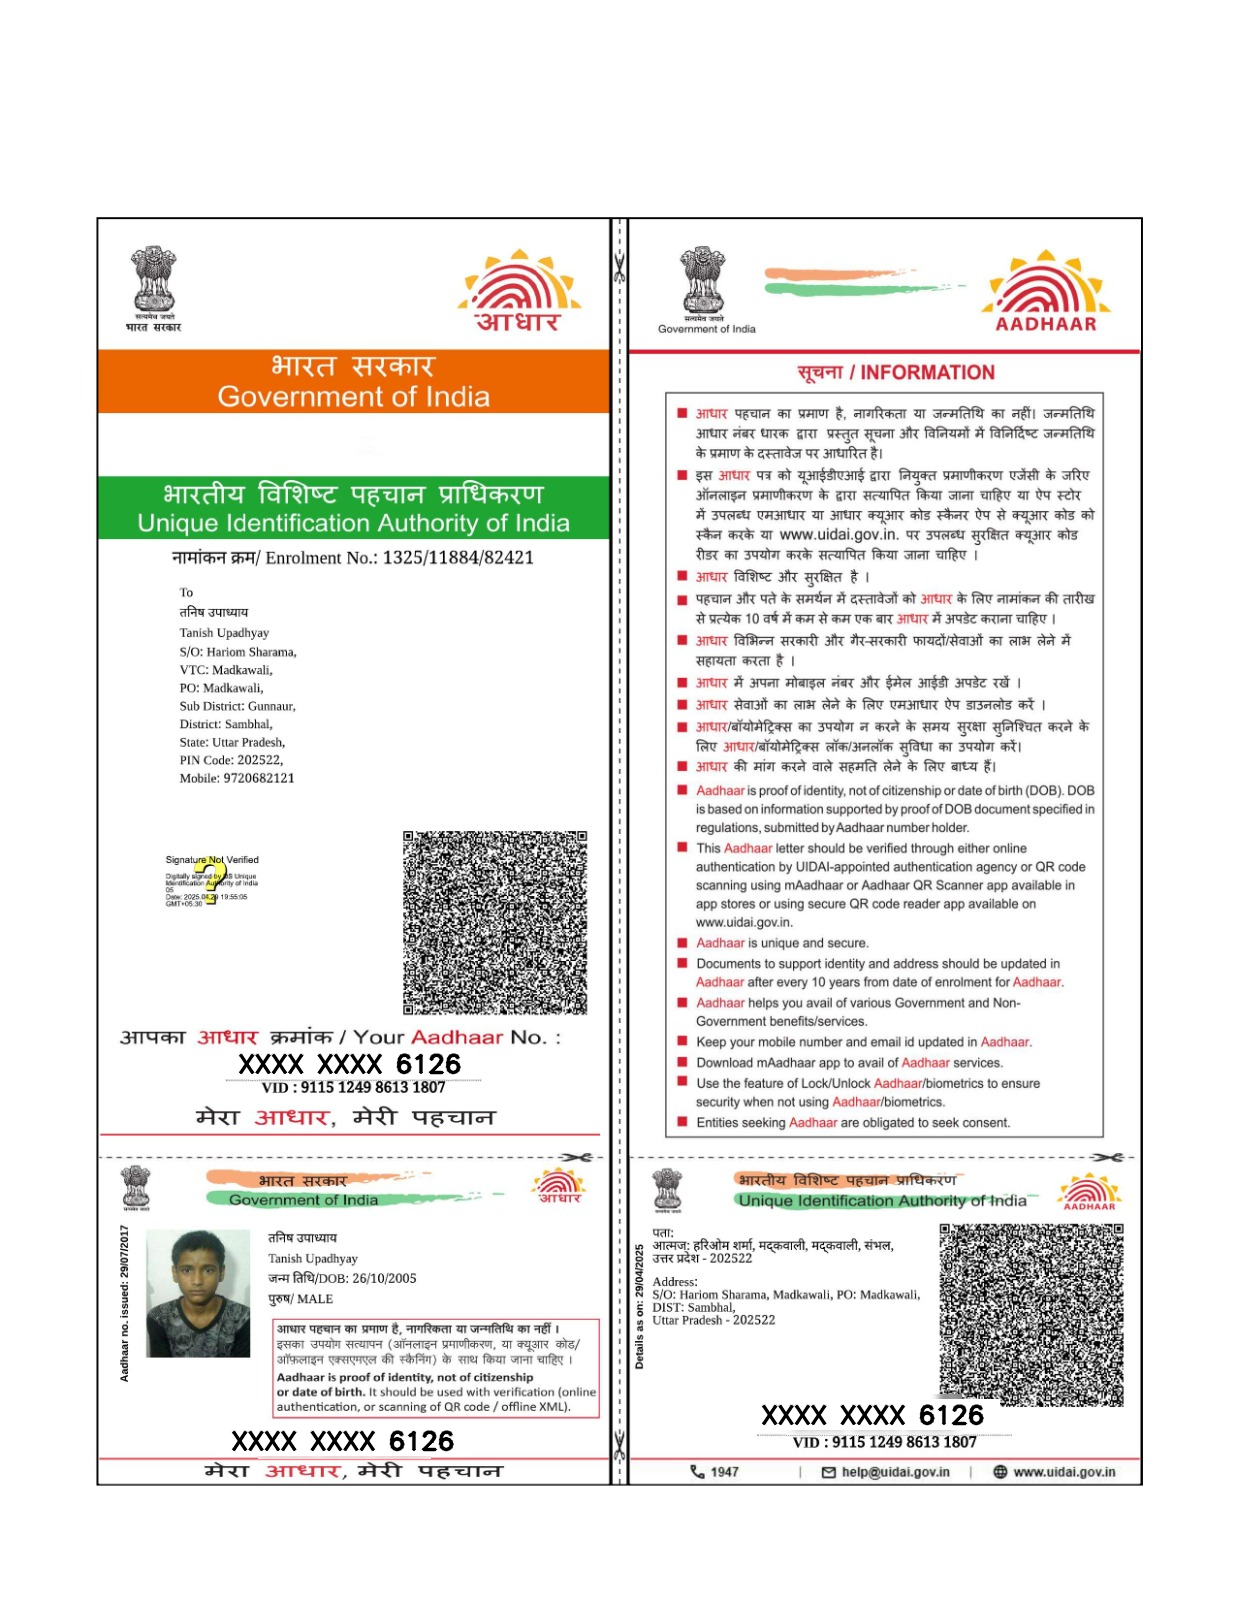

Saved masked image to: /content/aadhaar_masked_v2.png


In [5]:
# CELL 2
MODEL_PATH = "/content/drive/MyDrive/MIXED_AADHAR_NO_DETECT.pt"   # change if needed
IMAGE_PATH = "/content/drive/MyDrive/WhatsApp Image 2025-08-29 at 17.26.49_1d249ca7.jpg"                     # change to your image
OUTPUT_PATH = "/content/aadhaar_masked_v2.png"

# Run masking
masked_img = mask_aadhaar_image_v2(IMAGE_PATH, MODEL_PATH, output_path=OUTPUT_PATH)

# Display original and masked images under the cell (no new folders created)
from google.colab.patches import cv2_imshow
import cv2
print("Original Image:")
orig = cv2.imread(IMAGE_PATH)
cv2_imshow(orig)

print("Masked Image:")
cv2_imshow(masked_img)

print("Saved masked image to:", OUTPUT_PATH)

Original Image:


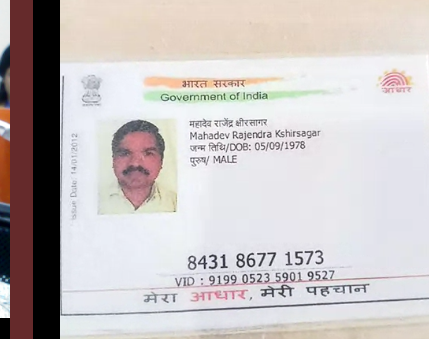

Masked Image:


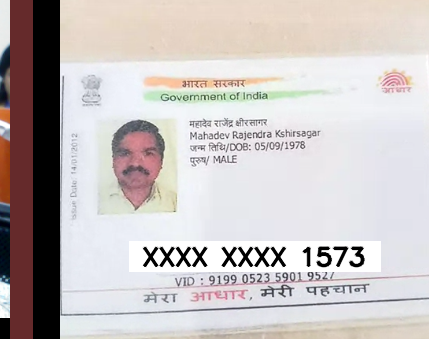

Saved masked image to: /content/aadhaar_masked_v2.png


In [7]:
# CELL 2
MODEL_PATH = "/content/drive/MyDrive/MIXED_AADHAR_NO_DETECT.pt"   # change if needed
IMAGE_PATH = "/content/drive/MyDrive/Test_image_1.png"                     # change to your image
OUTPUT_PATH = "/content/aadhaar_masked_v2.png"

# Run masking
masked_img = mask_aadhaar_image_v2(IMAGE_PATH, MODEL_PATH, output_path=OUTPUT_PATH)

# Display original and masked images under the cell (no new folders created)
from google.colab.patches import cv2_imshow
import cv2
print("Original Image:")
orig = cv2.imread(IMAGE_PATH)
cv2_imshow(orig)

print("Masked Image:")
cv2_imshow(masked_img)

print("Saved masked image to:", OUTPUT_PATH)

Original Image:


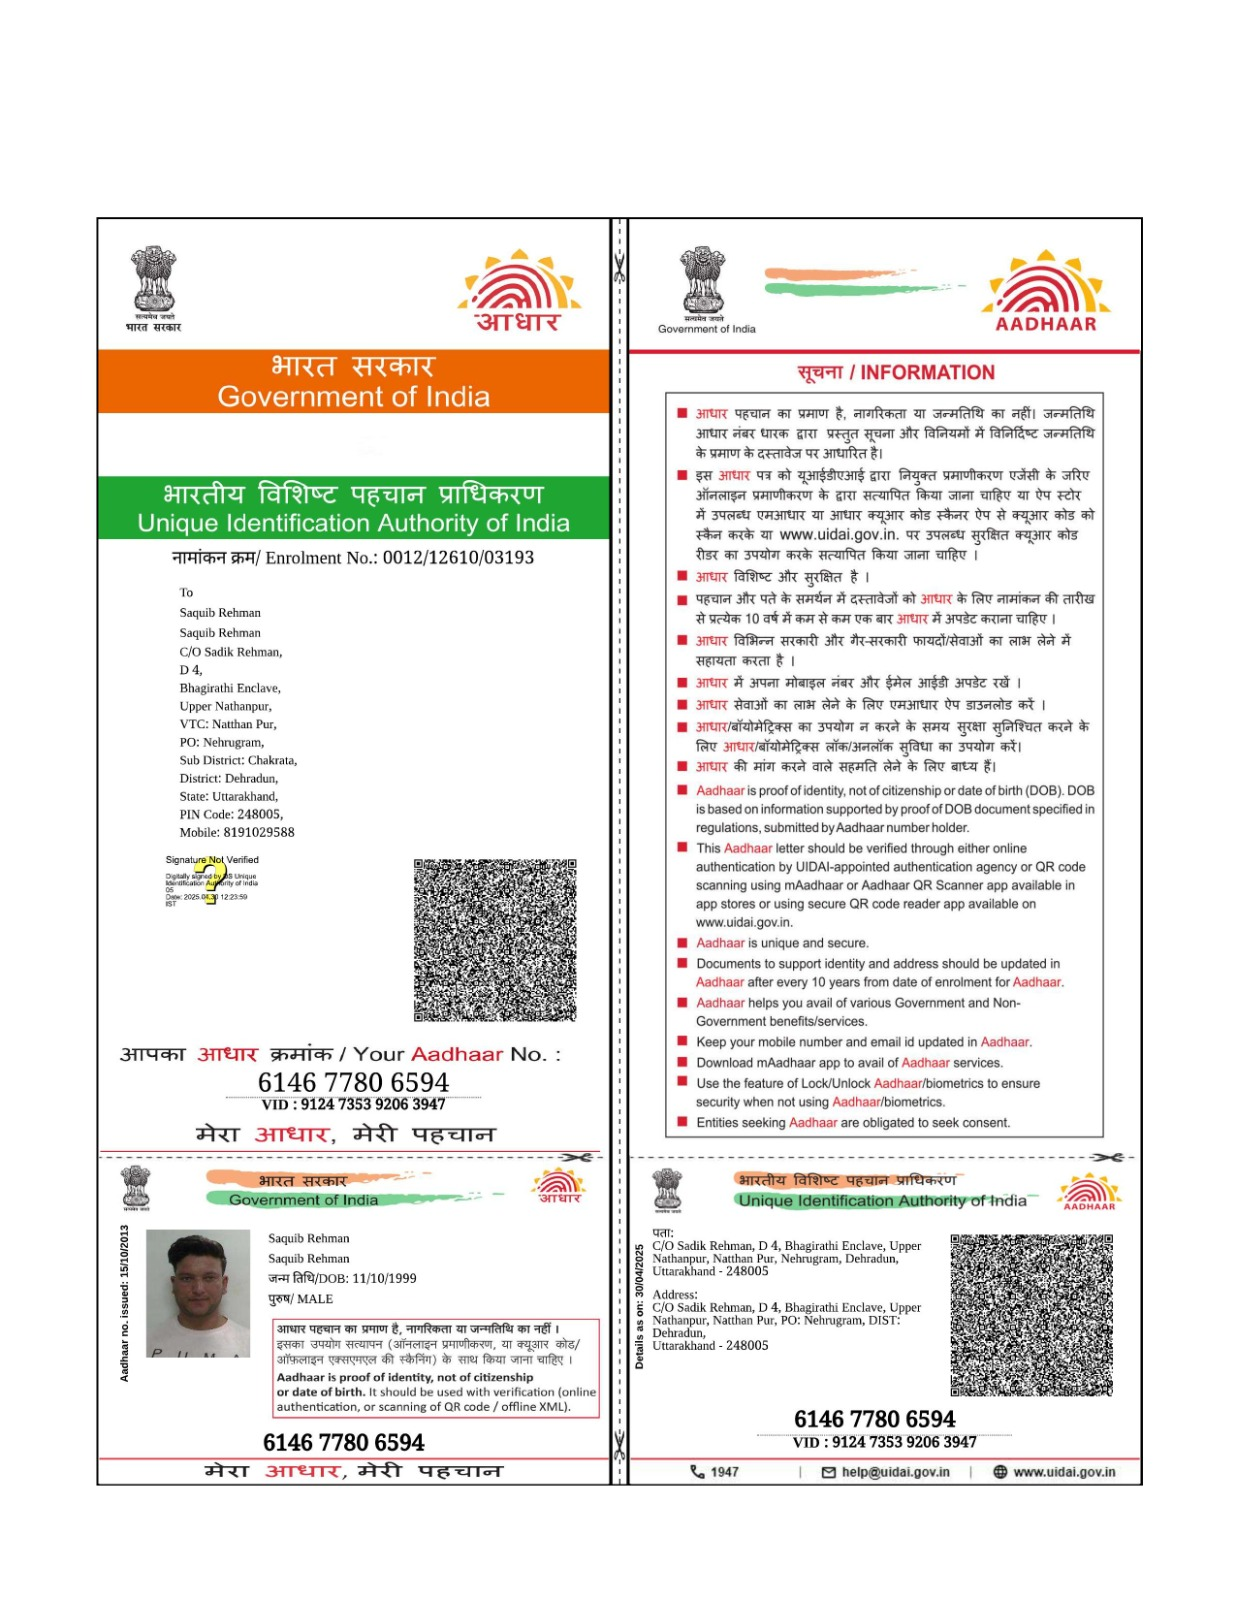

Masked Image:


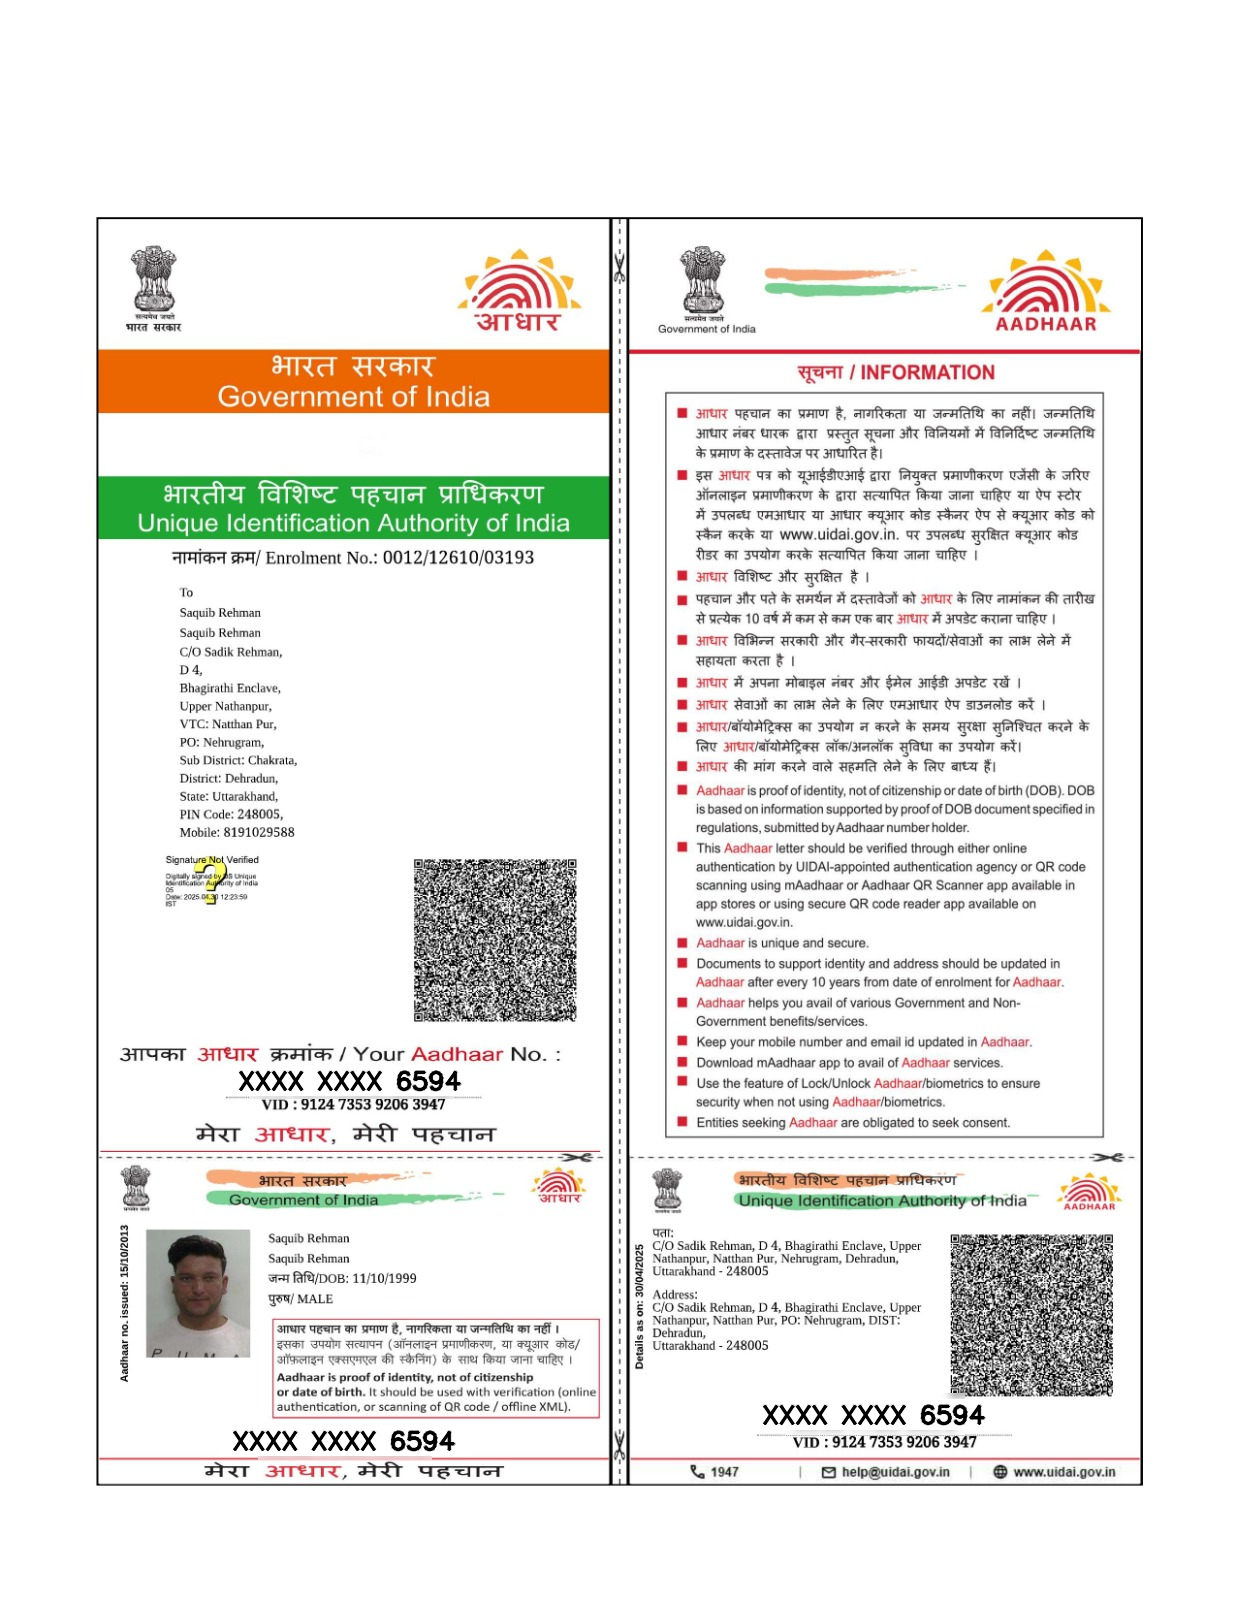

Saved masked image to: /content/aadhaar_masked_v2.png


In [6]:
# CELL 2
MODEL_PATH = "/content/drive/MyDrive/MIXED_AADHAR_NO_DETECT.pt"   # change if needed
IMAGE_PATH = "/content/drive/MyDrive/WhatsApp Image 2025-08-29 at 17.26.50_140e7567.jpg"                     # change to your image
OUTPUT_PATH = "/content/aadhaar_masked_v2.png"

# Run masking
masked_img = mask_aadhaar_image_v2(IMAGE_PATH, MODEL_PATH, output_path=OUTPUT_PATH)

# Display original and masked images under the cell (no new folders created)
from google.colab.patches import cv2_imshow
import cv2
print("Original Image:")
orig = cv2.imread(IMAGE_PATH)
cv2_imshow(orig)

print("Masked Image:")
cv2_imshow(masked_img)

print("Saved masked image to:", OUTPUT_PATH)

# **Run this CELL to check Predict endpoint**

In [11]:
# RUN THIS CELL AFTER you ran the CELL 1 that defines mask_aadhaar_image_v2(...)
# It creates a FastAPI app (using your notebook function), starts uvicorn and ngrok,
# and provides /predict (image) and /predict_debug (JSON + base64 image for debugging).

!pip install -q pyngrok

import os, io, socket, threading, time, base64
from pyngrok import ngrok, conf as ngrok_conf
import uvicorn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse, JSONResponse
import numpy as np
import cv2

# ---------- CONFIG ----------
MODEL_PATH = "/content/drive/MyDrive/MIXED_AADHAR_NO_DETECT.pt"   # change to your model path
NGROK_TOKEN = "30wITwj1k1u2Bc7PlH6px1TxixZ_5W2NizomZDy2DULyWR1pQ"                   # <-- set your token
HOST = "127.0.0.1"   # bind to localhost so ngrok can dial it
POLL_TIMEOUT = 30.0  # seconds to wait for uvicorn to bind
TMP_IN = "/content/tmp_input_upload.png"
# --------------------------------

# sanity: ensure mask function exists
try:
    mask_aadhaar_image_v2  # must be defined in previous cell
except NameError:
    raise RuntimeError("mask_aadhaar_image_v2 not found in the notebook. Run CELL 1 first.")

# kill old processes (best-effort)
os.system("pkill -f uvicorn || true")
os.system("pkill -f ngrok || true")
time.sleep(0.3)

def get_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind((HOST, 0))
    port = s.getsockname()[1]
    s.close()
    return port

PORT = get_free_port()
print("Chosen port:", PORT)

# Build FastAPI app using the notebook function
app = FastAPI(title="Aadhaar Masking API (notebook app)")

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """Return a masked PNG image (StreamingResponse)"""
    contents = await file.read()
    if not contents:
        return JSONResponse({"error": "empty file"}, status_code=400)
    # write temp file then call your function
    try:
        with open(TMP_IN, "wb") as f:
            f.write(contents)
    except Exception as e:
        return JSONResponse({"error": f"failed to write temp file: {e}"}, status_code=500)

    try:
        masked_bgr = mask_aadhaar_image_v2(TMP_IN, MODEL_PATH, output_path=None)
        if masked_bgr is None:
            return JSONResponse({"error": "mask function returned None"}, status_code=500)
    except Exception as e:
        return JSONResponse({"error": f"masking error: {repr(e)}"}, status_code=500)
    finally:
        try:
            os.remove(TMP_IN)
        except Exception:
            pass

    ok, enc = cv2.imencode(".png", masked_bgr)
    if not ok:
        return JSONResponse({"error": "cv2.imencode failed"}, status_code=500)
    return StreamingResponse(io.BytesIO(enc.tobytes()), media_type="image/png")

@app.post("/predict_debug")
async def predict_debug(file: UploadFile = File(...)):
    """
    Debug endpoint: returns detections from YOLO, the OCR-selected box, raw OCR text,
    extracted last4, and the masked image (base64).
    Useful to inspect why an uploaded image produced different output.
    """
    contents = await file.read()
    if not contents:
        return JSONResponse({"error": "empty file"}, status_code=400)
    try:
        with open(TMP_IN, "wb") as f:
            f.write(contents)
    except Exception as e:
        return JSONResponse({"error": f"failed to write temp file: {e}"}, status_code=500)

    # run the same masking flow but capture intermediate data
    debug_info = {"detections": [], "selected_idx": None, "ocr_text": None, "extracted_last4": None}
    try:
        # We mimic the inner steps of mask_aadhaar_image_v2 using the same model path and ocr settings
        from ultralytics import YOLO
        model = YOLO(MODEL_PATH)
        # read image with OpenCV so object identical
        import numpy as np
        nparr = np.frombuffer(contents, np.uint8)
        img_bgr = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        if img_bgr is None:
            # fallback
            from PIL import Image
            img = Image.open(io.BytesIO(contents)).convert("RGB")
            img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        h_img, w_img = img_bgr.shape[:2]

        results = model.predict(source=img_bgr, imgsz=640, conf=0.01, verbose=False)
        res0 = results[0]
        try:
            boxes_np = res0.boxes.xyxy.cpu().numpy().astype(int)
            confs_np = res0.boxes.conf.cpu().numpy().astype(float)
        except Exception:
            boxes_np = []
            confs_np = []
            for b in res0.boxes:
                boxes_np.append(b.xyxy[0].cpu().numpy().astype(int))
                confs_np.append(float(b.conf))
            boxes_np = np.array(boxes_np).astype(int) if len(boxes_np)>0 else np.empty((0,4), dtype=int)
            confs_np = np.array(confs_np).astype(float) if len(confs_np)>0 else np.array([])

        # populate detections list for debug return
        for i in range(len(boxes_np)):
            debug_info["detections"].append({"box": boxes_np[i].tolist(), "conf": float(confs_np[i]) if i < len(confs_np) else 0.0})

        # Choose highest-confidence box and OCR it (same heuristics as mask_aadhaar_image_v2)
        conf_keep_thresh = 0.05
        keep_mask = confs_np >= conf_keep_thresh if len(confs_np)>0 else np.array([], dtype=bool)
        if keep_mask.sum() == 0 and len(confs_np)>0:
            keep_mask = np.ones_like(confs_np, dtype=bool)
        boxes = boxes_np[keep_mask] if len(boxes_np)>0 else np.empty((0,4), dtype=int)
        confs = confs_np[keep_mask] if len(confs_np)>0 else np.array([])

        order = np.argsort(-confs) if len(confs)>0 else np.array([], dtype=int)
        extracted_number = None
        extracted_idx = None
        ocr_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'

        for idx in order:
            x1,y1,x2,y2 = boxes[idx]
            x1 = max(0, min(w_img-1, int(x1))); x2 = max(0, min(w_img-1, int(x2)))
            y1 = max(0, min(h_img-1, int(y1))); y2 = max(0, min(h_img-1, int(y2)))
            if x2 <= x1 or y2 <= y1:
                continue
            roi = img_bgr[y1:y2, x1:x2]
            if roi.size == 0:
                continue
            gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            up = max(1, int(3))
            gray_up = cv2.resize(gray, None, fx=up, fy=up, interpolation=cv2.INTER_LINEAR)
            _, th = cv2.threshold(gray_up, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            import pytesseract
            t1 = pytesseract.image_to_string(th, config=ocr_config)
            t2 = pytesseract.image_to_string(gray_up, config=ocr_config)
            text = t1 if sum(c.isdigit() for c in t1) >= sum(c.isdigit() for c in t2) else t2
            # use the notebook's extractor to be consistent
            num = extract_aadhaar_from_text(text)
            debug_info.setdefault("ocr_runs", []).append({"idx": int(idx), "text": text, "extracted": num})
            if num:
                extracted_number = num
                extracted_idx = int(idx)
                debug_info["ocr_text"] = text
                debug_info["selected_idx"] = extracted_idx
                debug_info["extracted_last4"] = num[-4:]
                break

        # call mask function to generate masked image (same as /predict)
        masked_bgr = mask_aadhaar_image_v2(TMP_IN, MODEL_PATH, output_path=None)

        # encode masked image to base64 so we can return it in JSON (for debugging)
        ok, enc = cv2.imencode(".png", masked_bgr)
        if not ok:
            raise RuntimeError("cv2.imencode failed")
        b64 = base64.b64encode(enc.tobytes()).decode("ascii")
        debug_info["masked_image_base64"] = b64

        return debug_info

    except Exception as e:
        return JSONResponse({"error": f"debugging error: {repr(e)}"}, status_code=500)
    finally:
        try:
            os.remove(TMP_IN)
        except Exception:
            pass

# Start uvicorn in background thread using notebook `app` object
def run_uvicorn():
    uvicorn.run(app, host=HOST, port=PORT, log_level="info")

# start server thread
server_thread = threading.Thread(target=run_uvicorn, daemon=True)
server_thread.start()

# wait until server is listening before creating ngrok tunnel
deadline = time.time() + POLL_TIMEOUT
listening = False
while time.time() < deadline:
    try:
        with socket.create_connection((HOST, PORT), timeout=1):
            listening = True
            break
    except Exception:
        time.sleep(0.25)

if not listening:
    raise RuntimeError(f"uvicorn did not start listening on {HOST}:{PORT} within {POLL_TIMEOUT}s. Check server logs.")

# create ngrok tunnel AFTER server is ready
public_url = None
if NGROK_TOKEN and "PASTE_YOUR_NGROK_AUTHTOKEN_HERE" not in NGROK_TOKEN:
    try:
        ngrok_conf.get_default().auth_token = NGROK_TOKEN
        public_url = ngrok.connect(addr=PORT)
    except Exception as e:
        print("ngrok.connect failed:", e)
        public_url = None
else:
    print("NGROK_TOKEN not set or placeholder — ngrok tunnel not created.")

local_swagger = f"http://127.0.0.1:{PORT}/docs"
print("Server is up and listening.")
print("Local docs (in VM):", local_swagger)
if public_url:
    print("Public ngrok docs:", f"{public_url}/docs")
else:
    print("No public ngrok URL. Set NGROK_TOKEN and re-run this cell for a public URL.")

Chosen port: 38203


INFO:     Started server process [496]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:38203 (Press CTRL+C to quit)


Server is up and listening.
Local docs (in VM): http://127.0.0.1:38203/docs
Public ngrok docs: NgrokTunnel: "https://3894f056af2c.ngrok-free.app" -> "http://localhost:38203"/docs
